https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

import os

import matplotlib.pyplot as plt

In [13]:
# Import the data from CSV
this_dir = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(this_dir, 'house_data')
train = pd.read_csv(data_path + '\\train.csv')
test = pd.read_csv(data_path + '\\test.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Look at prevalence of missing values
train.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64

In [4]:
# Look at the distribution of numeric values a bit
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
# Check the numerical variables that correlate most strongly with the Y target
train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

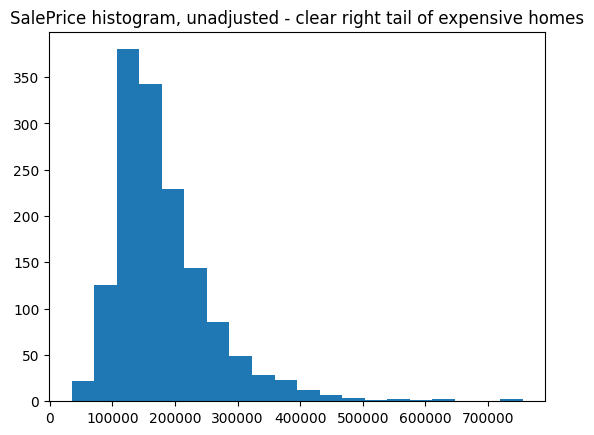

In [6]:
# Plot Y variable
plt.hist(train['SalePrice'], bins=20)
plt.title('SalePrice histogram, unadjusted - clear right tail of expensive homes')
plt.show()

In [14]:
# Preprocess the data
# Take the log of saleprice to reduce right skew of housing prices
train['SalePrice'] = np.log1p(train['SalePrice'])

def clean_columns(df):
    # Fill missing numerical values
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(0)

    # Fill missing object values
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna("None")

    # Convert categoricals to 'category' dtype for native handling
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
    return df

train = clean_columns(train)

X = train.drop('SalePrice', axis=1)
y = train[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
base_X_train, base_X_test, base_y_train, base_y_test = X_train.iloc[:,:].copy(), X_test.iloc[:,:].copy(), y_train.iloc[:,:].copy(), y_test.iloc[:,:].copy()

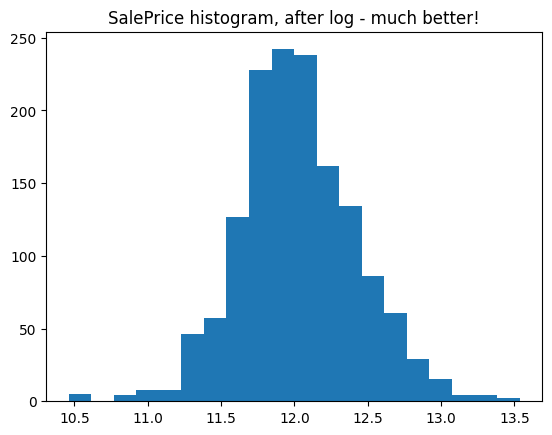

In [8]:
# Plot adjusted Y variable
plt.hist(y['SalePrice'], bins=20)
plt.title('SalePrice histogram, after log - much better!')
plt.show()

MSE from XGBRegressor = 0.0198

In [9]:
# Try an XGBoost Regressor since it can handle categoricals and tends to perform pretty well

# First get the X and y data from before the model run, just ease of running multiple models on the same data
X_train, X_test, y_train, y_test = base_X_train.iloc[:,:].copy(), base_X_test.iloc[:,:].copy(), base_y_train.iloc[:,:].copy(), base_y_test.iloc[:,:].copy()

# Model with categoricals enabled
model = XGBRegressor(
    random_state=0,
    enable_categorical=True,
    objective='reg:squarederror',
    tree_method='hist'
)

# Grid search parameters to try
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10, 15, 20],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=4
)

# Train and retrieve best model
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions and get fit, also output some sample values
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(mse)
# Get the original non-log price
y_test['Y'] = np.expm1(y_test['SalePrice'])
# Get the predicted non-log price
y_test['Pred'] = np.expm1(preds)
y_test.head(10)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'colsample_bytree': 0.7, 'gamma': 0, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}
0.019779212772846222


,SalePrice,Y,Pred
529,12.209193,200624.0,265972.968750
491,11.798112,133000.0,147684.546875
459,11.608245,110000.0,99707.851562
279,12.165256,192000.0,214761.171875
655,11.385103,88000.0,89722.976562
1013,11.350418,85000.0,107724.156250
1403,12.552930,282922.0,257380.312500
601,11.856522,141000.0,125193.546875
1182,13.521141,745000.0,615515.125000
687,11.910365,148800.0,158231.359375


MSE from RandomForestRegressor = 0.0200

In [10]:
# Try a RandomForestRegressor because why not?

# First get the X and y data from before the model run, just ease of running multiple models on the same data
X_train, X_test, y_train, y_test = base_X_train.iloc[:,:].copy(), base_X_test.iloc[:,:].copy(), base_y_train.iloc[:,:].copy(), base_y_test.iloc[:,:].copy()

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# One-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave numeric features untouched
)

# Pipeline with preprocessing and RF model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0, n_jobs=-1))
])

# Grid search parameters to try, with regressor__ pretag so the Pipeline works properly
param_grid = {
    'regressor__n_estimators': [500, 1000],
    'regressor__max_depth': [5, 10, 15, 20],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=4
)

# Train and retrieve best model
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions and get fit, also output some sample values
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(mse)
# Get the original non-log price
y_test['Y'] = np.expm1(y_test['SalePrice'])
# Get the predicted non-log price
y_test['Pred'] = np.expm1(preds)
y_test.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\jwesi\Documents\GitHub\MovieLens-Data-Science\movielens_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500}
0.02002481516608338


,SalePrice,Y,Pred
529,12.209193,200624.0,214043.231333
491,11.798112,133000.0,136648.771238
459,11.608245,110000.0,126584.436271
279,12.165256,192000.0,202996.339523
655,11.385103,88000.0,98356.838488
1013,11.350418,85000.0,105475.457036
1403,12.552930,282922.0,233294.781269
601,11.856522,141000.0,130698.945683
1182,13.521141,745000.0,411473.532426
687,11.910365,148800.0,157690.864473


In [ ]:
# Not a lot of data to train on but let's try a neural net anyways!

# First get the X and y data from before the model run, just ease of running multiple models on the same data
X_train, X_test, y_train, y_test = base_X_train.iloc[:,:].copy(), base_X_test.iloc[:,:].copy(), base_y_train.iloc[:,:].copy(), base_y_test.iloc[:,:].copy()

# Separate categorical and numeric columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Ordinal encode categoricals with per-column unknown handling
cat_dims = []
X_train_enc = X_train[cat_cols].copy()
X_test_enc = X_test[cat_cols].copy()

for col in cat_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=X_train[col].nunique())
    X_train_enc[[col]] = encoder.fit_transform(X_train[[col]].astype(str))
    X_test_enc[[col]] = encoder.transform(X_test[[col]].astype(str))
    cat_dims.append(X_train_enc[col].max() + 1)  # +1 for unknown category

X_train[cat_cols] = X_train_enc
X_test[cat_cols] = X_test_enc

# Normalize numeric features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Combine all features
X_train_processed = X_train[cat_cols + num_cols].copy()
X_test_processed = X_test[cat_cols + num_cols].copy()

# Define datasets
class HouseDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.X_cat = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.X_num = torch.tensor(X[num_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]
    
train_ds = HouseDataset(X_train_processed, y_train, cat_cols, num_cols)
test_ds = HouseDataset(X_test_processed, y_test, cat_cols, num_cols)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Define model
class NN(nn.Module):
    def __init__(self, cat_dims, num_dim):
        super().__init__()
        # Embed based on the square root of the unique entries in the categorical column
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, min(50, int((cat_dim + 1)  ** 0.5))) for cat_dim in cat_dims
        ])
        emb_dim = sum([emb.embedding_dim for emb in self.embeddings])
        input_dim = emb_dim + num_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            # nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            # nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = torch.cat([x, x_num], dim=1)
        return self.net(x)

# Define the size of the embeddings based on the unique number of valuables in each categorical column
cat_dims = [int(X_train[col].nunique()) + 1 for col in cat_cols]
model = NN(cat_dims=cat_dims, num_dim=len(num_cols))

# Training (and testing) loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(250):
    model.train()
    for x_cat, x_num, y in train_loader:
        x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
        preds = model(x_cat, x_num)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for x_cat, x_num, y in test_loader:
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            preds = model(x_cat, x_num).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(y.cpu().numpy()) 

    val_preds = np.array(val_preds).flatten()
    val_targets = np.array(val_targets).flatten()
    val_loss = mean_squared_error(val_targets, val_preds)

    print(f"Epoch {epoch+1}, Val MSE: {val_loss:.4f}")

# Get the predicted values for the full dataframe
# Switch model to eval mode
model.eval()

# Collect predictions on test set
all_preds = []
all_targets = []

with torch.no_grad():
    for x_cat, x_num, y in test_loader:
        x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
        preds = model(x_cat, x_num)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Concatenate and inverse log-transform
all_preds = np.vstack(all_preds).flatten()
all_targets = np.vstack(all_targets).flatten()

# Calculate MSE on original scale
mse = mean_squared_error(all_targets, all_preds)
print(mse)

# Output sample predictions
results_df = pd.DataFrame({
    'SalePrice': all_targets,
    'LogPred': all_preds
})

# Get the original non-log price
results_df['Y'] = np.expm1(results_df['SalePrice'])
# Get the predicted non-log price
results_df['Pred'] = np.expm1(results_df['LogPred'])

# Standardize number format
pd.set_option('display.float_format', '{:.6f}'.format)
results_df.drop('LogPred', axis=1).head(10)

Epoch 1, Val MSE: 31.1545
Epoch 2, Val MSE: 1.1674
Epoch 3, Val MSE: 0.9029
Epoch 4, Val MSE: 0.7433
Epoch 5, Val MSE: 0.6588
Epoch 6, Val MSE: 0.5467
Epoch 7, Val MSE: 0.4896
Epoch 8, Val MSE: 0.4735
Epoch 9, Val MSE: 0.4041
Epoch 10, Val MSE: 0.3802
Epoch 11, Val MSE: 0.3289
Epoch 12, Val MSE: 0.3126
Epoch 13, Val MSE: 0.3213
Epoch 14, Val MSE: 0.2822
Epoch 15, Val MSE: 0.2529
Epoch 16, Val MSE: 0.2331
Epoch 17, Val MSE: 0.2275
Epoch 18, Val MSE: 0.1959
Epoch 19, Val MSE: 0.1838
Epoch 20, Val MSE: 0.1831
Epoch 21, Val MSE: 0.1703
Epoch 22, Val MSE: 0.1514
Epoch 23, Val MSE: 0.1525
Epoch 24, Val MSE: 0.1388
Epoch 25, Val MSE: 0.1429
Epoch 26, Val MSE: 0.1204
Epoch 27, Val MSE: 0.1175
Epoch 28, Val MSE: 0.1132
Epoch 29, Val MSE: 0.1213
Epoch 30, Val MSE: 0.1024
Epoch 31, Val MSE: 0.1125
Epoch 32, Val MSE: 0.1076
Epoch 33, Val MSE: 0.0936
Epoch 34, Val MSE: 0.0920
Epoch 35, Val MSE: 0.1151
Epoch 36, Val MSE: 0.0928
Epoch 37, Val MSE: 0.0874
Epoch 38, Val MSE: 0.0843
Epoch 39, Val MSE: 0

,SalePrice,Y,Pred
0,12.209193,200624.093750,235329.640625
1,11.798112,133000.000000,147464.859375
2,11.608245,110000.015625,132881.078125
3,12.165256,191999.937500,189825.500000
4,11.385103,87999.976562,79480.109375
5,11.350418,84999.984375,75200.843750
6,12.552930,282921.937500,254926.203125
7,11.856523,141000.046875,128040.523438
8,13.521141,745000.187500,794083.937500
9,11.910365,148800.000000,154687.718750
